In [1]:
import pandas as pd

train_essays = pd.read_csv('train_data/train_essays.csv')
train_essays = train_essays.dropna(how='all')


test_df = pd.read_csv('train_data//test_essays.csv')  # Read CSV file into a DataFrame
test_df


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [2]:
sample_submission = pd.read_csv("train_data/sample_submission.csv")
sample_submission

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [3]:
train_essays['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [4]:
train_essays[train_essays['generated']==0].head(5)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
train_essays[(train_essays['prompt_id']==0) & (train_essays["generated"]==1)]

,id,prompt_id,text,generated
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


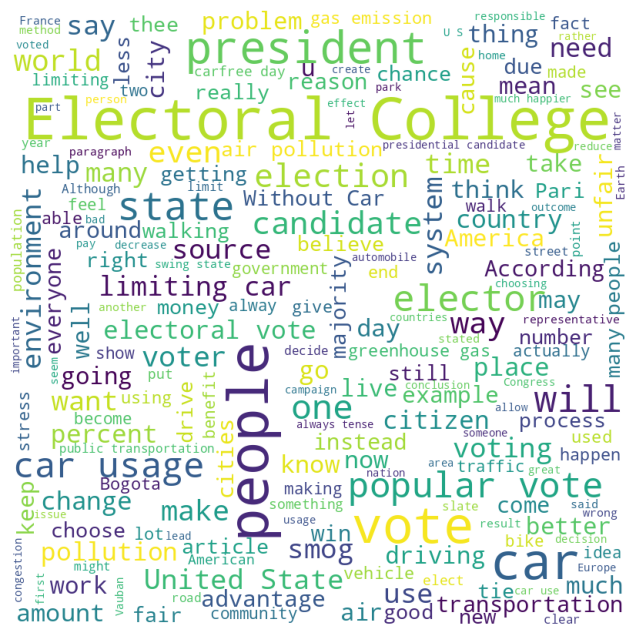

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(width = 800,height=800,background_color='white',min_font_size=10)
wc.generate(''.join(train_essays[train_essays["generated"]==0]['text']))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [7]:
import matplotlib. pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import transformers as ppb
import swifter
from tqdm.auto import tqdm
tqdm.pandas()
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

/home/nimai/python/text-ml/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df = train_essays[['text','generated']]
print(df.head(2))
X = df['text']
Y = df['generated']
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3)

                                                text  generated
0  Cars. Cars have been around since they became ...          0
1  Transportation is a large necessity in most co...          0


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-05-30 22:20:18.644314: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 22:20:18.650482: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 22:20:18.723033: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 22:20:19.023127: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 22:20:20.956263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [10]:
tokenizer = Tokenizer(oov_token='<00V>')
tokenizer.fit_on_texts(x_train)
vocab_len = len(tokenizer.index_word)

In [11]:
train_sequences = tokenizer.texts_to_sequences(x_train)

In [12]:
doc_length = []
for doc in train_sequences:
    doc_length.append(len(doc))
    
max(doc_length)

1300

In [13]:
import numpy as np

max_len = np.quantile(doc_length,0.95)
max_len = int(max_len)

print(f"95% of text has {max_len} length")

95% of text has 857 length


In [14]:
train_padded = pad_sequences(train_sequences,maxlen = int(max_len))
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences,maxlen = max_len)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Flatten

In [46]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=10, input_length=max_len, mask_zero=True))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/nimai/python/text-ml/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
model.summary()
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.fit(train_padded,y_train,validation_data = (test_padded,y_test),epochs=20,batch_size = 10,verbose=False)

model.save('./model/nim_bert_model.h5')

/home/nimai/python/text-ml/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


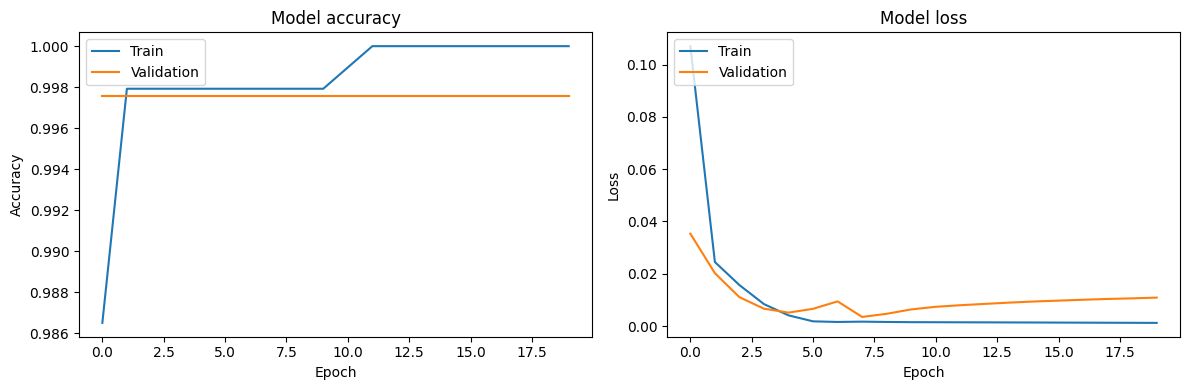

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
text_sequences = tokenizer.texts_to_sequences(test_df['text'])
X_test= pad_sequences(text_sequences, maxlen=max_len)

print(max_len)

857


In [52]:
import keras

data =  pd.read_csv("./train_data/test_essays.csv")


model2 =  keras.models.load_model("./model/nim_bert_model.h5")
max_len = 870
text_sequences = tokenizer.texts_to_sequences(data['text'])
X_test= pad_sequences(text_sequences, maxlen=max_len)
# Initialize an array to store predictions for each fold
fold_preds = np.zeros(shape=(len(test_df),), dtype='float32')

y = model2.predict(X_test)
fold_preds += y.squeeze()

fold_preds

/home/nimai/python/text-ml/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 8570, but received input with shape (3, 8700)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(3, 870), dtype=int32)
  • training=False
  • mask=None

In [37]:
# Initialize an array to store predictions for each fold
fold_preds = np.zeros(shape=(len(test_df),), dtype='float32')

y = model.predict(X_test)
fold_preds += y.squeeze()

fold_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


array([0.5170504, 0.5170504, 0.5170504], dtype=float32)

In [ ]:
submission_df = test_df[["id"]].copy()

# Add the formatted predictions to the submission DataFrame
submission_df["generated"] = fold_preds.squeeze()

In [ ]:
submission_df

,id,generated
0,0000aaaa,0.517186
1,1111bbbb,0.517186
2,2222cccc,0.517186


In [ ]:
submission_df.to_csv('submission.csv',index=False)

In [ ]:
p = model.predict(test_df['text'])


/home/nimai/python/text-ml/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 8600, but received input with shape (3, 10)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(3, 1), dtype=string)
  • training=False
  • mask=None